In [1]:
import cv2
import numpy as np
import os
from matplotlib import pyplot as plt
from sklearn import preprocessing
from inspect import signature
from sklearn.metrics import precision_recall_curve

In [2]:
base_data_folder = 'data/'

In [3]:
def show_image(img, title="", size = 10):
    plt.figure(figsize=(size,size))
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    if title:
        plt.title(title)
    
def read_img(filename):
    return cv2.imread(base_data_folder + filename)

1. Write a program to extract the color histogram of each of the 2,000 images. Choose the
parameters required with justifications. Implement your own histogram code and compare its
results with open-source API like OpenCV and numpy

https://docs.opencv.org/master/dd/d0d/tutorial_py_2d_histogram.html

In [4]:
hist_shape = (50,50)
max_hue = 180
max_saturation = 256

def hist_cv(image):
    channels = [0, 1]  # hue and saturation
    mask = None
    hsv = cv2.cvtColor(image,cv2.COLOR_BGR2HSV)
    hist = cv2.calcHist([hsv], channels, mask, hist_shape, [0, max_hue, 0, max_saturation])
    
    # Scale histogram
    hist = preprocessing.normalize(hist, norm='max')
    return hist

def hist_np(image):
    hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
    # hue and saturations channels
    hist, x_bins, y_bins = np.histogram2d(
        hsv[:,:,0].ravel(),hsv[:,:,1].ravel(), hist_shape,[[0,max_hue],[0,max_saturation]]
    )
    
    # Scale histogram
    hist = preprocessing.normalize(hist, norm='max')
    return hist

def hist_custom(image):
    h, w, channels = image.shape
    hsv = cv2.cvtColor(image,cv2.COLOR_BGR2HSV)
    
    hist = np.zeros(hist_shape) 
    hist_h, hist_w = hist_shape
    for i in range(h):
        for j in range(w):
            hue = hsv[i, j, 0]
            saturation = hsv[i, j, 1]
            hue_bin = int(hist_h * hue/ max_hue)
            saturation_bin = int(hist_w * saturation / max_saturation)
            hist[hue_bin, saturation_bin] += 1
            
    # Scale histogram
    hist = preprocessing.normalize(hist, norm='max')
    return hist  

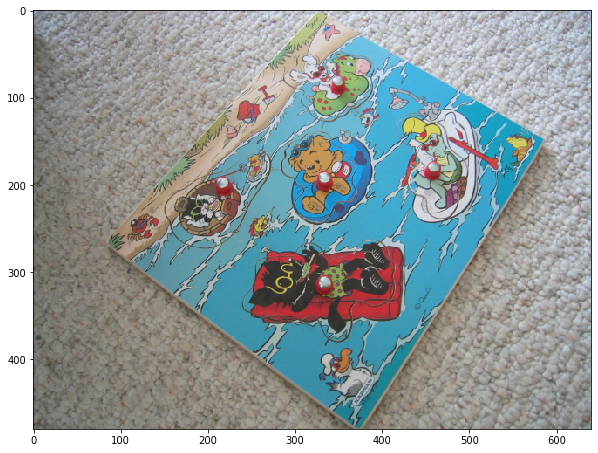

In [5]:
img = read_img("ukbench00000.jpg")
show_image(img)

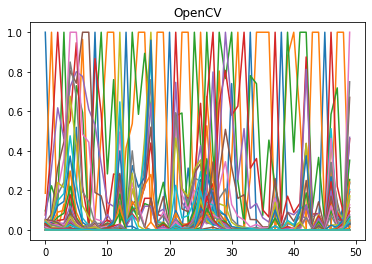

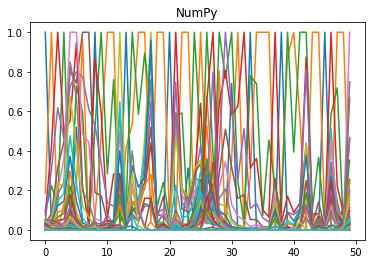

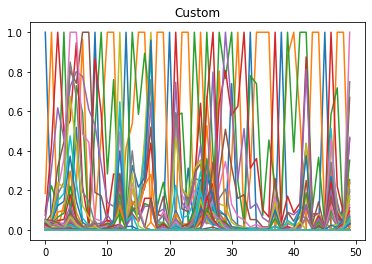

In [6]:
plt.plot(hist_cv(img))
plt.title("OpenCV")
plt.show()
plt.plot(hist_np(img))
plt.title("NumPy")
plt.show()
plt.plot(hist_custom(img))
plt.title("Custom")
plt.show()

In [7]:
image_names = sorted(os.listdir(base_data_folder))
images = [read_img(name) for name in image_names]
histograms = [hist_cv(img) for img in images]

2. Write a program to measure the L2 distance between color histograms of two images.


In [8]:
def l2_distance(hist1, hist2):
    return np.linalg.norm(np.subtract(hist1, hist2))

In [9]:
l2_distance(histograms[0], histograms[1])

2.6966498

3. Use 5 images shown above (ukbench00004.jpg; ukbench00040.jpg; ukbench00060.jpg;
ukbench00588.jpg; ukbench01562.jpg) as queries. For each query image, find 10 best matches
from the 2,000 images based on the color histogram similarity.
Plot the query image and the 10 returned matches (use icons of reduced resolution to save
space).

In [10]:
top_count = 10
images_to_query = [4, 40, 60, 588, 1562]
def hist_similarity(idx, histograms, top_count=10):
    l2_distances = [l2_distance(histograms[idx], hist) for hist in histograms]
    top_hists = np.argsort(l2_distances)
    return top_hists[:top_count]

<Figure size 432x288 with 0 Axes>

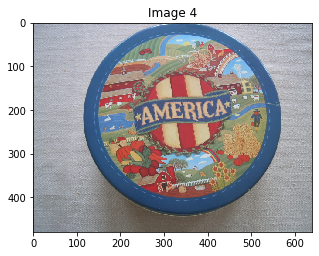

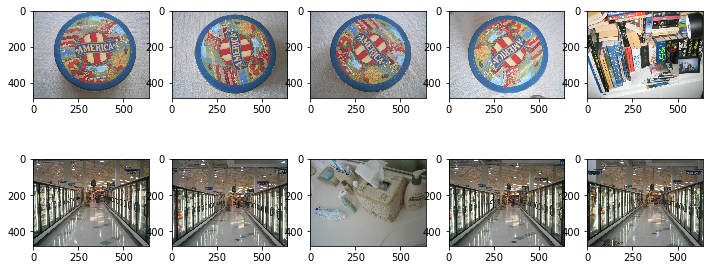

<Figure size 432x288 with 0 Axes>

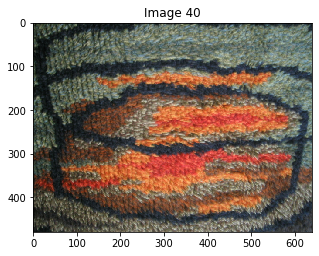

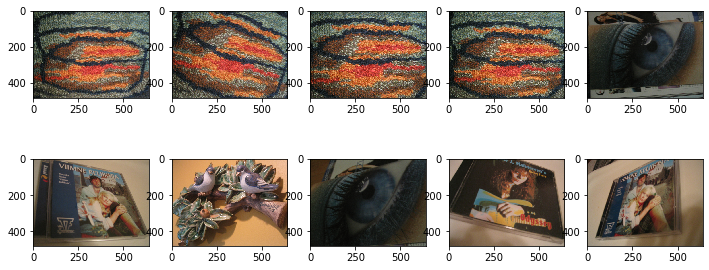

<Figure size 432x288 with 0 Axes>

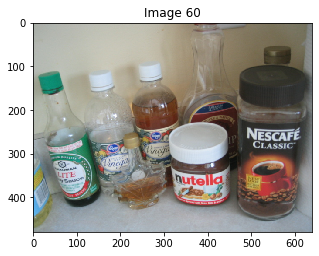

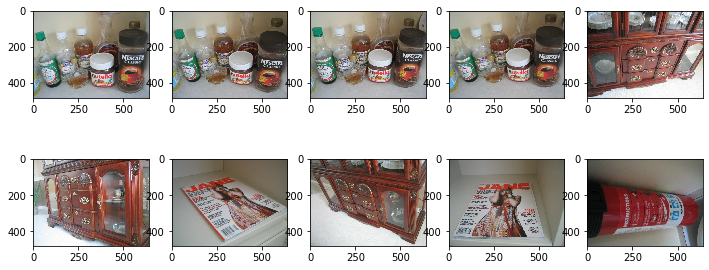

<Figure size 432x288 with 0 Axes>

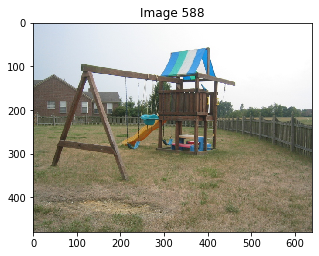

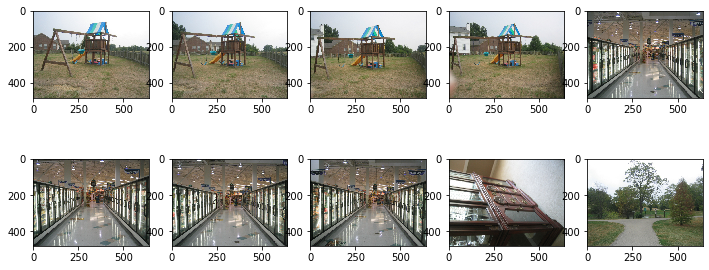

<Figure size 432x288 with 0 Axes>

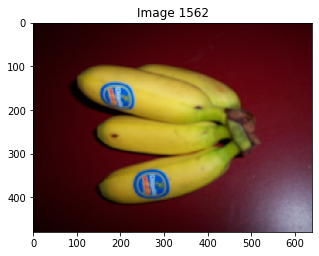

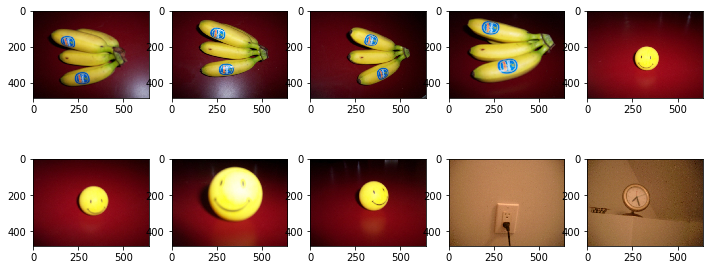

In [11]:
for img_to_query in images_to_query:
    plt.figure()
    show_image(images[img_to_query], "Image {}".format(img_to_query), 5)
    
    cols = 5
    rows = int(top_count / cols)
    fig, axes = plt.subplots(rows, cols)
    fig.set_size_inches(12, 5)
    
    for idx, image_idx in enumerate(hist_similarity(img_to_query, histograms, top_count)):
        axes[int(idx // cols), idx % cols].imshow(cv2.cvtColor(images[image_idx], cv2.COLOR_BGR2RGB))
plt.show()

All 5 queries have first 4 images from the same group of images (groups contains 4 images)

4. Write a program to measure and plot the P-R curve for each query.

https://scikit-learn.org/stable/auto_examples/model_selection/plot_precision_recall.html

In [12]:
def p_r_curve(true_values, scores):
    precision, recall, _ = precision_recall_curve(true_values, scores)
    
    step_kwargs = ({'step': 'post'} if 'step' in signature(plt.fill_between).parameters else {})
    plt.step(recall, precision, color='b', alpha=0.2, where='post')
    plt.fill_between(recall, precision, alpha=0.2, color='b', **step_kwargs)

    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.ylim([0.0, 1.05])
    plt.xlim([0.0, 1.0])
    plt.show()

true:     [1. 1. 1. 1. 0. 0. 0. 0. 0. 0.]
predicted:[1. 1. 1. 1. 0. 0. 0. 0. 0. 0.]


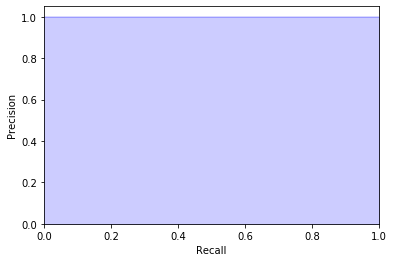

true:     [1. 1. 1. 1. 0. 0. 0. 0. 0. 0.]
predicted:[1. 1. 1. 1. 0. 0. 0. 0. 0. 0.]


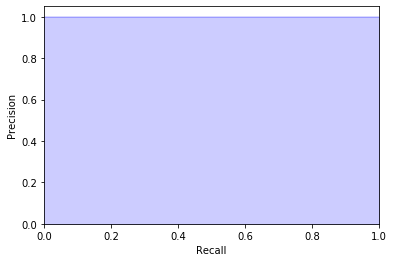

true:     [1. 1. 1. 1. 0. 0. 0. 0. 0. 0.]
predicted:[1. 1. 1. 1. 0. 0. 0. 0. 0. 0.]


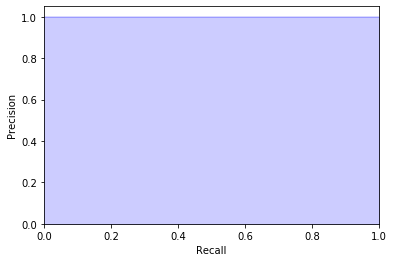

true:     [1. 1. 1. 1. 0. 0. 0. 0. 0. 0.]
predicted:[1. 1. 1. 1. 0. 0. 0. 0. 0. 0.]


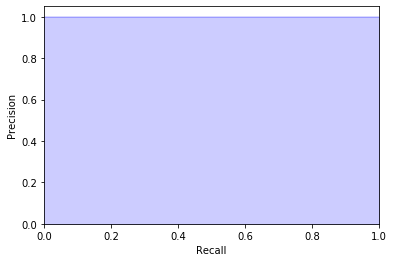

true:     [1. 1. 1. 1. 0. 0. 0. 0. 0. 0.]
predicted:[1. 1. 1. 1. 0. 0. 0. 0. 0. 0.]


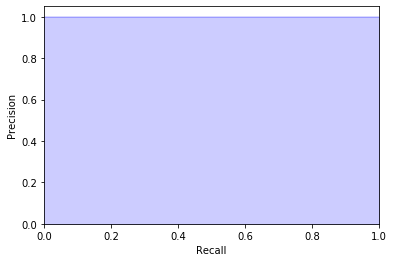

In [13]:
for img_to_query in images_to_query:
    image_indexes = hist_similarity(img_to_query, histograms, top_count)
    predicted = np.zeros(10)
    true = np.zeros(10)
    images_in_group = 4
    start_group_index = int(img_to_query / images_in_group) * images_in_group
    for (i,item) in enumerate(image_indexes):
        if item in range(start_group_index, start_group_index + images_in_group):
            predicted[i] = 1
        if i < images_in_group:
            true[i] = 1
            
    print('true:     {}'.format(true))
    print('predicted:{}'.format(predicted))
    p_r_curve(true, predicted)

As we already have seen in the step 3.: all 5 queries have first 4 images from the same group of images (groups contains 4 images)

5. Discuss and explain success and failure cases.


Using hue and saturation of HSV channels with histogram gives very good results. All 5 queries had 4 images from the same group at the first four places, which is correct.
Other images from top10 images looks similar in terms of colors, so the results are correct.